In [85]:
import os
import glob
import json
import h5py
import optparse
import sys
import traceback
import copy
import re

import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
import scipy.stats as spstats
import statsmodels as sm
import cPickle as pkl
import tifffile as tf

import numpy as np
from scipy.optimize import leastsq
import pylab as pl


from pipeline.python import utils as putils
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import experiment_classes as util

In [86]:
%matplotlib notebook

In [5]:
rootdir = '/n/coxfs01/2p-data'

#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)


In [6]:
#### Set output dir
outdir = os.path.join(aggregate_dir, 'quality-checks', 'area-assignment')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/quality-checks/area-assignment


In [7]:
fov_keys = aggr.get_sorted_fovs()

In [9]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [10]:
pp.pprint(fov_keys)

{   'JC076': {   'Li': [('20190422_fov1', '20190502_fov1')],
                 'Lm': ['20190423_fov1'],
                 'V1': [('20190420_fov1', '20190501_fov1')]},
    'JC078': {   'Lm': [   ('20190426', '20190504', '20190509'),
                           ('20190430', '20190513')]},
    'JC080': {   'Li': ['20190602_fov1'],
                 'Lm': [('20190506', '20190603'), '20190602_fov2']},
    'JC083': {   'Lm': [('20190508', '201905012', '20190517')],
                 'V1': [('20190507', '20190510', '2010511')]},
    'JC084': {   'Lm': ['20190525'], 'V1': ['20190522']},
    'JC085': {   'V1': ['20190622']},
    'JC089': {   'Li': ['20190522']},
    'JC090': {   'Li': ['20190605']},
    'JC091': {   'Li': [   ('20190602', '20190607'),
                           ('20190606', '20190614'),
                           ('20191007', '20191008')],
                 'Lm': ['20190627']},
    'JC092': {   'Li': ['20190527_fov2', '20190527_fov3', '20190528']},
    'JC097': {   'Lm': ['20190615_f

In [176]:
import tifffile as tf
import cv2

from pipeline.python.coregistration.align_fov import Animal, FOV, warp_im


In [144]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC113'

coreg_dir = os.path.join(rootdir, animalid, 'coreg')
coreg_dfile = os.path.join(coreg_dir, 'FOVs.pkl')

with open(coreg_dfile, 'rb') as f:
    A = pkl.load(f)

curr_fovs = A.session_list.keys()
print("Found %i fovs." % len(curr_fovs))



Found 5 fovs.


In [168]:
session = '20191018'

fkey = [f for f in curr_fovs if session in f][0]
fov_ = A.session_list[fkey]


In [169]:
for k, v in fov_.alignment.items():
    if isinstance(v, dict):
        print(k, v.keys())
    else:
        print(k, v.shape)

('transform_matrix', (3, 3))
('aligned', (492, 656))
('coreg_points', ['reference_points_x', 'reference_points_y', 'sample_points_x', 'sample_points_y'])


In [170]:
dir(fov_)

['__doc__',
 '__init__',
 '__module__',
 'acquisition',
 'alignment',
 'animalid',
 'coreg_dir',
 'get_transformed_image',
 'image',
 'image_fpath',
 'image_path',
 'meta',
 'pixel_size',
 'rootdir',
 'scale_anatomicals',
 'session',
 'transform_anatomicals']

In [173]:
data_id = '%s_%s' % (fov_.session, fov_.animalid)
data_id

'20191018_JC113'

<IPython.core.display.Javascript object>


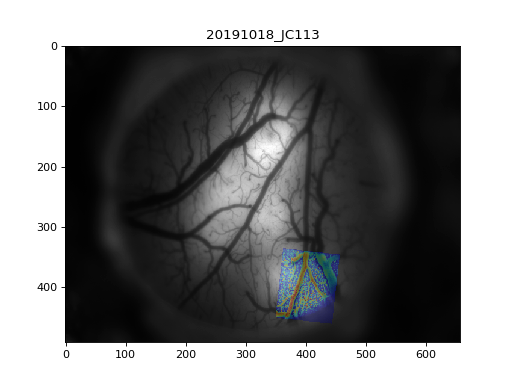

Text(0.5,1,u'20191018_JC113')

In [175]:
vasculature = A.reference.copy()
fov_img = fov_.image.copy()
fov_transf = fov_.alignment['aligned']


aligned_msk = fov_transf.copy()
aligned_msk[fov_transf==0] = np.nan

pl.figure()
pl.imshow(vasculature, cmap='gray')
pl.imshow( aligned_msk, cmap='jet', alpha=0.3)

pl.title(data_id)

In [147]:
for fkey, fov_ in A.session_list.items():
    try:
        print(fkey, fov_.pixel_size)
    except AttributeError:
        print(fkey)

('20191017_FOV1_zoom2p0x', (2.312, 1.888))
('20191012_FOV3_zoom2p0x', (2.312, 1.888))
('20191018_FOV1_zoom2p0x', (2.312, 1.888))
('20191012_FOV2_zoom2p0x', (2.312, 1.888))
('20191012_FOV1_zoom2p0x', (2.312, 1.888))


## Warp fov w/ transf matrix

In [182]:
session

'20191018'

In [177]:
from pipeline.python.rois import utils as roi_utils

In [180]:
traceid= 'traces001'
roi_id = roi_utils.get_roiid_from_traceid(animalid, session, fov, traceid=traceid)
roi_masks, roi_proj = roi_utils.load_roi_masks(animalid, session, fov, rois=roi_id)
print("Loaded rois: %s" % roi_id)
print(roi_masks.shape)

Loaded rois: rois001
(512, 512, 210)


<IPython.core.display.Javascript object>


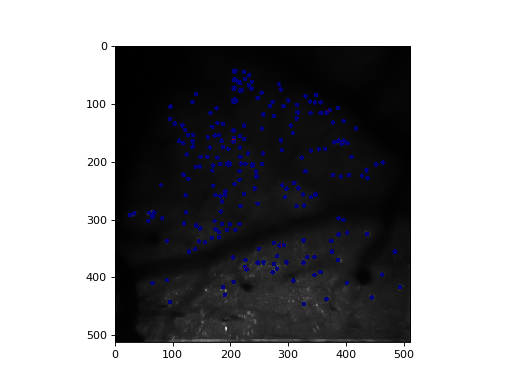

In [181]:
roi_img = np.sum(roi_masks, axis=-1)
roi_msk = roi_img.copy()
roi_msk[roi_img==0] = np.nan

pl.figure()
pl.imshow(roi_proj, cmap='gray')
pl.imshow(roi_msk, cmap='jet')


#### Transform roi image to match widefield

#### Apply warp

In [ ]:
warped_im = warp_im(roi_img.astype(float), transform_mat, vasculature.shape)


#### Load area boundaries

In [141]:
callable(getattr(fov_, 'transform_anatomicals'))

True

In [132]:
dir(fov_)

['__doc__',
 '__init__',
 '__module__',
 'acquisition',
 'alignment',
 'animalid',
 'coreg_dir',
 'get_transformed_image',
 'image',
 'image_fpath',
 'image_path',
 'meta',
 'rootdir',
 'scale_anatomicals',
 'session',
 'transform_anatomicals']

In [142]:
f.close()

AttributeError: 'str' object has no attribute 'close'

In [89]:
# load anatomical (transformed)

def load_anatomical(animalid, session, fov, fmt='tif', channel_id=2, rootdir='/n/coxfs01/2p-data'):

    anat_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov, 'anatomical', \
                                        'anatomical_Channel%02d*scaled.%s' % (channel_id, fmt)))[0]
    
    if fmt=='tif':
        img = tf.imread(anat_fpath)
    else:
        img = cv2.imread(anat_fpath)
        
    if len(img.shape)>2:
        img = img[:, :, 0]
    
    return img

<IPython.core.display.Javascript object>


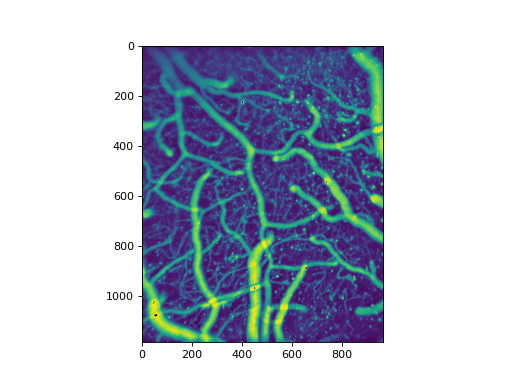

In [91]:
zimg = load_anatomical(animalid, session, fov, fmt=fmt)
pl.figure()
pl.imshow(zimg)

In [74]:
xaxis_conversion = 2.31 #2.312 # goes with A-P axis
yaxis_conversion = 1.89  #1.904 # goes with M-L axis

d1, d2 = img.shape # (im_h, im_w)
new_d1 = int(round(d1*xaxis_conversion, 1)) # after transform, 
new_d2 = int(round(d2*yaxis_conversion, 1)) # after transform, d2~ML axis (width), 
zimg_r = cv2.resize(im, (new_d2, new_d1))   # (new_d1~COLS, new_d2~ROWS)
print(zimg_r.shape)
print(new_d1, new_d2)

In [83]:
img.size

262144

<IPython.core.display.Javascript object>


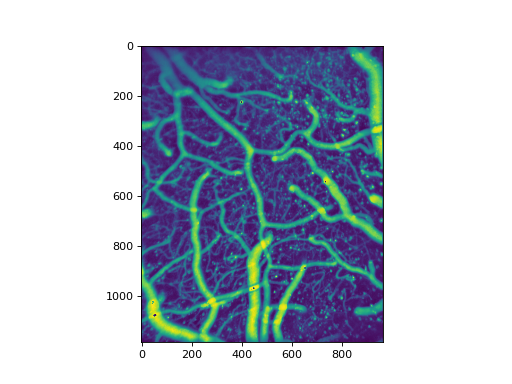

In [84]:
pl.figure()
pl.imshow(zimg_r)

In [60]:
img_outpath = '%s_scaled2.%s' % (os.path.splitext(anat_fpath)[0], fmt)

if fmt=='tif':
    tf.imsave(img_outpath, zimg_r)
else:
    cv2.imwrite(img_outpath, zimg_r)



True

In [63]:
tf.im

AttributeError: 'module' object has no attribute 'im'

In [ ]:
('saved results: ', '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC076_20190404/20190404_MJC076_results.pkl')